In [1]:
import os
import time

import keras
import numpy as np
from IPython.display import clear_output

import datagen
import dataset
import embedding_model
import eval
import inference
import loss_functions
import postprocessing
import utils
import visual
from params import Params
from torch.utils import data

Using TensorFlow backend.


In [2]:
params = Params()

params.EMBEDDING_DIM            = 24
params.BACKBONE                 = 'xception'
params.BATCH_SIZE               = 1
params.NUM_SHAPE                = 6
params.NUM_CLASSES              = 4 # (3 shapes + 1 background)
params.NUM_FILTER               = [256, 128]
params.ETH_MEAN_SHIFT_THRESHOLD = 1.5
params.DELTA_VAR                = 0.5
params.DELTA_D                  = 1.5
params.IMG_SIZE                 = 256
params.OUTPUT_SIZE              = 64
params.EPOCHS                   = 20
params.STEPS                    = 1000
params.STEPS_PER_VISUAL         = 100

model = embedding_model.ImageEmbeddingModel(params)
optim = keras.optimizers.Adam(lr = 1e-4)
loss_function = loss_functions.single_frame_loss_with_params(params)
model.compile(optim, loss = loss_function)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



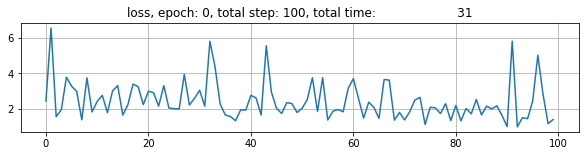

IndexError: too many indices for array

In [5]:
train_dataset = dataset.FastImageDataset(params)
train_dataloader = data.DataLoader(
    train_dataset, 
    batch_size=1, 
    num_workers=8, 
    pin_memory=True, 
    drop_last=True)
generator = datagen.ImageDataGenerator(params.NUM_SHAPE, params.IMG_SIZE)
step = 0
starting_time = time.time()
loss_history = []
for epoch in range(params.EPOCHS):
    for x, y in train_dataloader:
        step += 1
#         image_info = generator.get_image()
#         x, y = utils.prep_single_frame(image_info)
        history = model.fit(x, y, batch_size = 1, verbose = False)
        latest_loss = history.history['loss'][-1]
        loss_history.append(latest_loss)
        if step % params.STEPS_PER_VISUAL == 0:
            clear_output(wait=True)
            elapsed_time = int(time.time() - starting_time)
            utils.visualize_history(
                loss_history, 
                f'loss, epoch: {epoch}, total step: {step}, total time: \
                    {elapsed_time}')
            image_info = generator.get_image()
            x, y = utils.prep_single_frame(image_info)
            visual.single_eval(model, x, y, params)
    model.save_weights(f'model/single_frame_epoch_{epoch}.h5')